In [1]:
!pip install tensorflow

In [2]:
# !pip install --upgrade numpy

In [3]:
# pip install --upgrade sklearn

# INTRODUCTION

In [4]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import csv


C:\Users\Abeer\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
data = pd.read_csv('../sale_price_prediction_data.csv')


# Correlation Matrix

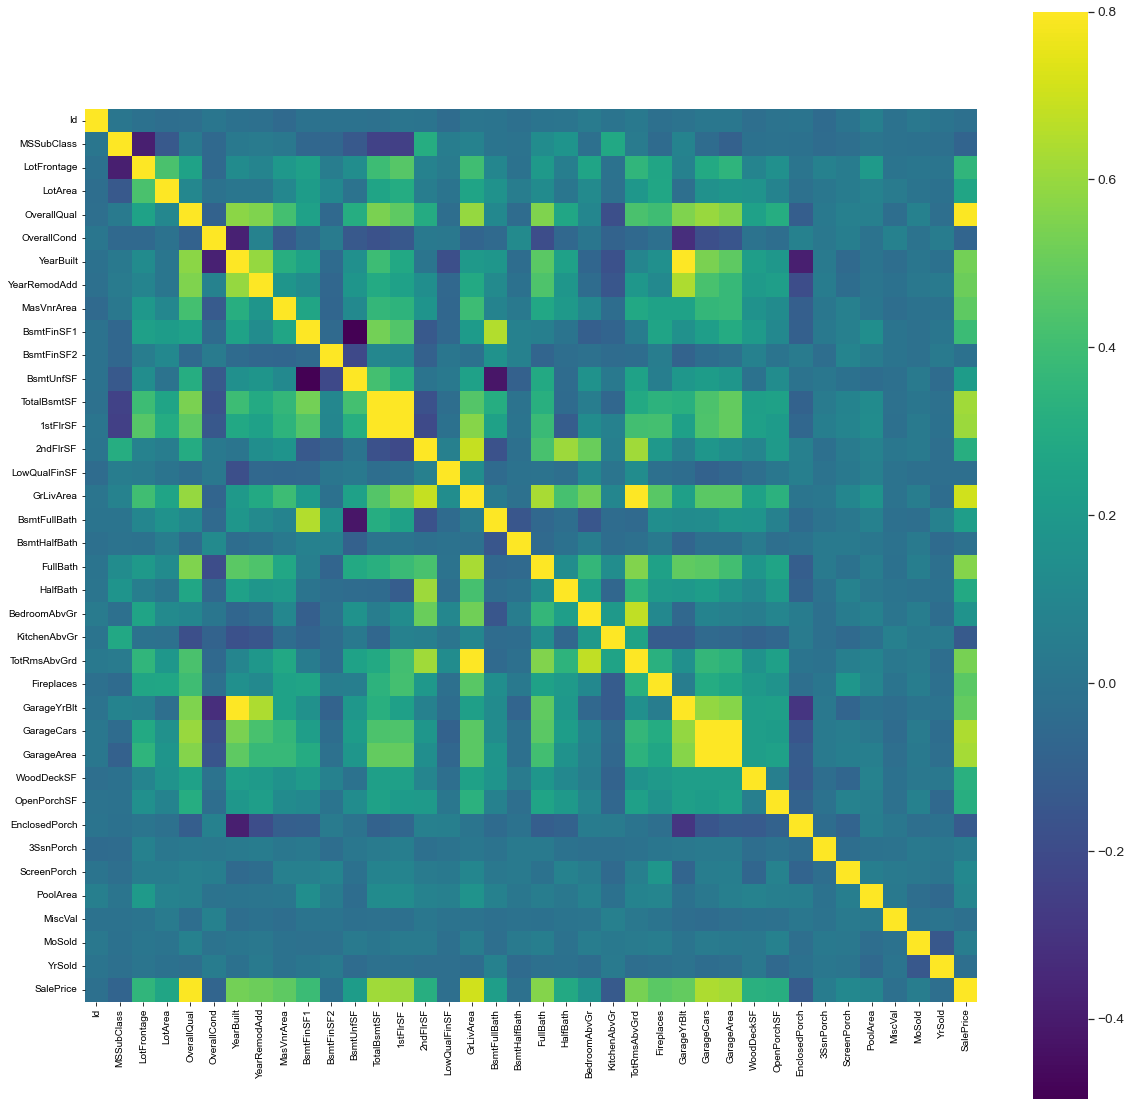

In [6]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, annot = False, vmax=0.8, square=True, annot_kws={'size': 10},cmap = 'viridis');




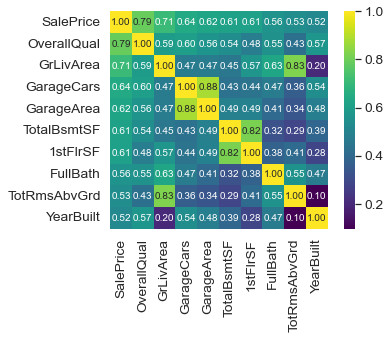

In [7]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap = 'viridis')
plt.show()

In [8]:
key_features = ['SalePrice',  'OverallQual', 'GrLivArea',  'GarageCars',  'GarageArea' , 'TotalBsmtSF' , '1stFlrSF' , 'FullBath' , 'TotRmsAbvGrd' , 'YearBuilt']
key_data = pd.DataFrame(data[key_features])
print(key_data)

      SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0        208500            7       1710           2         548          856   
1        181500            6       1262           2         460         1262   
2        223500            7       1786           2         608          920   
3        140000            7       1717           3         642          756   
4        250000            8       2198           3         836         1145   
...         ...          ...        ...         ...         ...          ...   
1455     175000            6       1647           2         460          953   
1456     210000            6       2073           2         500         1542   
1457     266500            7       2340           1         252         1152   
1458     142125            5       1078           1         240         1078   
1459     147500            5       1256           1         276         1256   

      1stFlrSF  FullBath  TotRmsAbvGrd 


# Linear Regression

In [9]:
# Spliting target variable and independent variables
X = key_data.drop(['SalePrice'], axis = 1)
y = key_data['SalePrice']
# Splitting to training and testing data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 4)

In [10]:
print('------------Linear Regression-----------------')
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)



------------Linear Regression-----------------


LinearRegression()

In [36]:
#Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})


# Assuming y_true and y_pred are your true and predicted labels, respectively

print(coeffcients)



      Attribute  Coefficients
0   OverallQual  20787.496014
1     GrLivArea     42.984611
2    GarageCars  13873.537883
3    GarageArea      9.302723
4   TotalBsmtSF     19.650762
5      1stFlrSF     14.509994
6      FullBath  -1657.401717
7  TotRmsAbvGrd   1871.260348
8     YearBuilt     296.26157
R^2: 0.7542949980583503
Adjusted R^2: 0.7521098745232961
MAE: 25208.102512861726
MSE: 1650101095.9439173
RMSE: 40621.436409166
R^2: 0.8114288930849451
Adjusted R^2: 0.8074636127993482
MAE: 23265.090808383535
MSE: 1007378936.6797862
RMSE: 31739.23339779627


In [37]:

# Model prediction on train data
y_pred = lm.predict(X_train)
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

# Predicting Test data with the model
y_test_pred = lm.predict(X_test)
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
mae_linreg = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_linreg = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_linreg)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_linreg)

R^2: 0.7542949980583503
Adjusted R^2: 0.7521098745232961
MAE: 25208.102512861726
MSE: 1650101095.9439173
RMSE: 40621.436409166
R^2: 0.8114288930849451
Adjusted R^2: 0.8074636127993482
MAE: 23265.090808383535
MSE: 1007378936.6797862
RMSE: 31739.23339779627


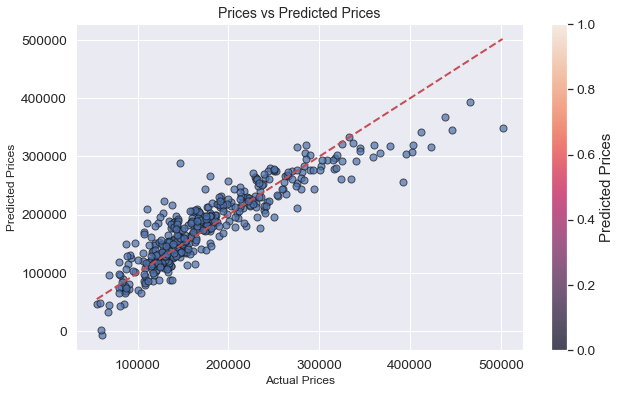

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_test_pred, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


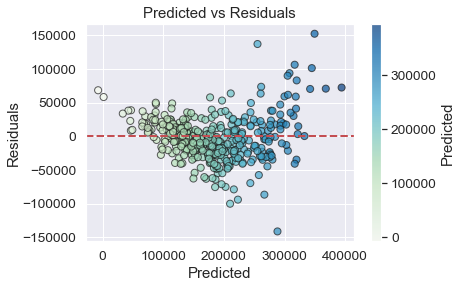

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom color palette resembling a cluster of dots
palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

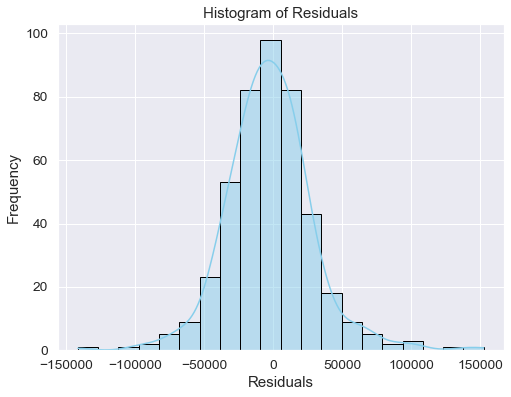

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom color palette
sns.set_palette("pastel")

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# XG BOOST

In [16]:
print('------------XGBoost Regressor-----------------')
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg = XGBRegressor()

# Train the model using the training sets
reg.fit(X_train, y_train)

# Model prediction on train data
y_pred = reg.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

#Predicting Test data with the model
y_test_pred = reg.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
mae_xgb = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_xgb)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_xgb)



------------XGBoost Regressor-----------------
------------Train Set-----------------
R^2: 0.9979555898518911
Adjusted R^2: 0.9979374083387162
MAE: 2641.9182133683953
MSE: 13729811.763272041
RMSE: 3705.3760623278226
------------Test Set-----------------
R^2: 0.8409578907510531
Adjusted R^2: 0.8376135473322668
MAE: 20213.224734232306
MSE: 849630007.0757202
RMSE: 29148.413457265906


C:\Users\Abeer\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Abeer\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


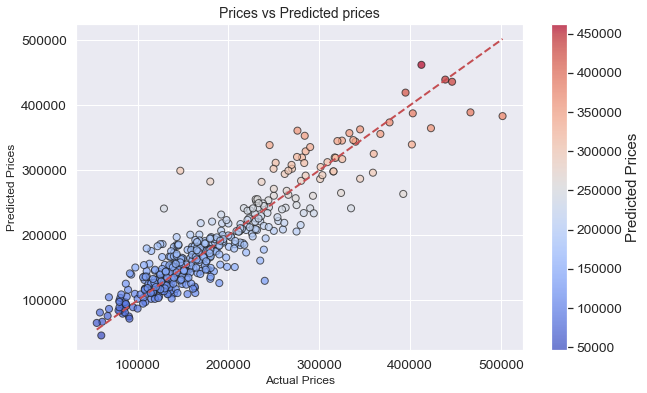

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


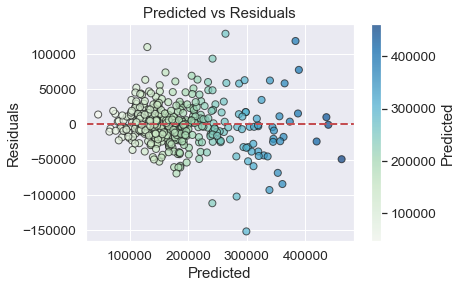

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom color palette resembling a cluster of dots
palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()


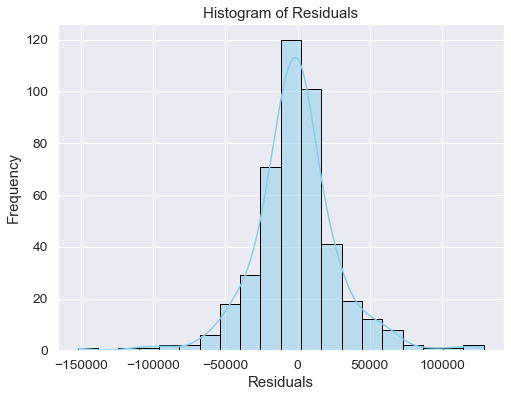

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom color palette
sns.set_palette("pastel")

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


<Figure size 432x288 with 0 Axes>

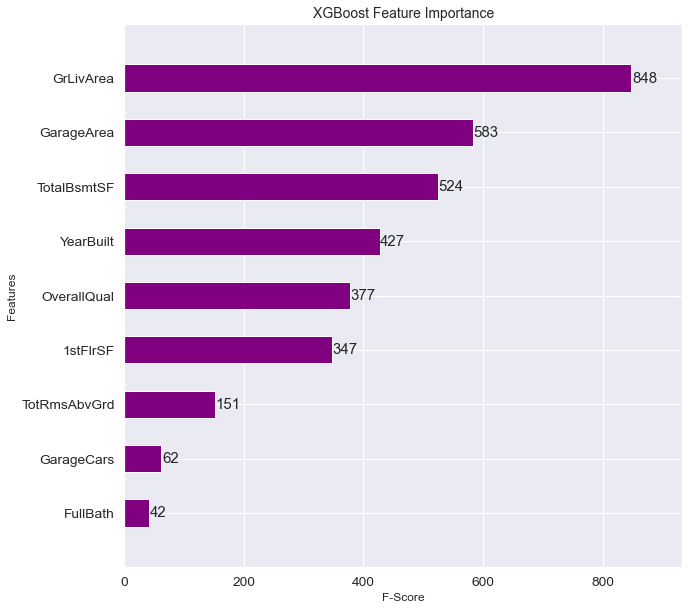

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Set a custom color palette
sns.set_palette("GnBu")

# Create a figure and axis
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the importance chart
plot_importance(reg, height=0.5, max_num_features=64, ax=ax, color='purple')

# Customize labels and title
plt.xlabel("F-Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)

# Show the plot
plt.show()


# SVM

In [21]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_test, y_train, y_test are already defined

# Feature scaling (recommended for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVR model
svm_regressor = SVR(kernel='rbf')  # 'rbf' kernel is commonly used
svm_regressor.fit(X_train_scaled, y_train)

# Model prediction on train data
y_train_pred = svm_regressor.predict(X_train_scaled)

# Model Evaluation for training data
print('Training Set Metrics:')
print('R^2:', metrics.r2_score(y_train, y_train_pred))
print('MAE:', metrics.mean_absolute_error(y_train, y_train_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

# Predicting Test data with the model
y_test_pred = svm_regressor.predict(X_test_scaled)

# Model Evaluation for test data
print('\nTesting Set Metrics:')
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))


Training Set Metrics:
R^2: -0.04175380889588354
MAE: 56391.73377058221
MSE: 6996190912.593133
RMSE: 83643.23590460338

Testing Set Metrics:
R^2: -0.03075648093075989
MAE: 53270.59312755599
MSE: 5506476494.320921
RMSE: 74205.6365400966


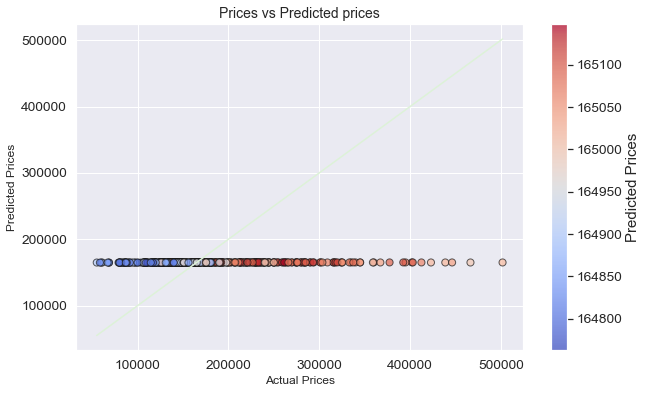

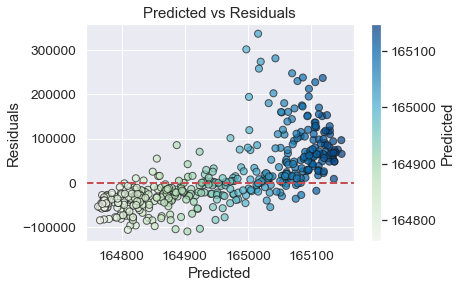

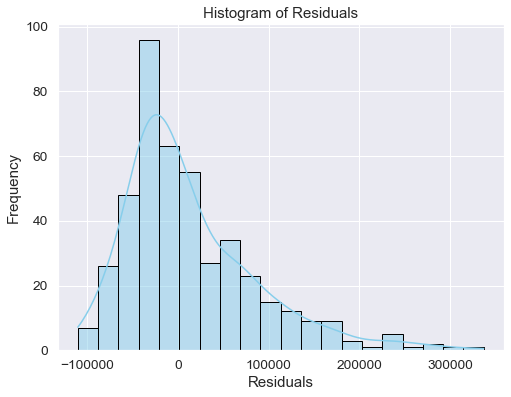

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
palette = sns.color_palette('viridis')

# Visualizing the differences between actual prices and predicted values

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.grid(True)
plt.show()

# Checking residuals

palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


# Neural Network

In [23]:
import numpy as np
import pandas as pd
import tensorflow
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming X_train, X_test, y_train, y_test are already defined

# Feature scaling (recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# Model prediction on train data
y_train_pred = model.predict(X_train_scaled).flatten()

# Model Evaluation for training data
print('Training Set Metrics:')
print('R^2:', metrics.r2_score(y_train, y_train_pred))
print('MAE:', metrics.mean_absolute_error(y_train, y_train_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

# Predicting Test data with the model
y_test_pred = model.predict(X_test_scaled).flatten()

# Model Evaluation for test data
print('\nTesting Set Metrics:')
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))


Epoch 1/50
32/32 [==============================] - 1s 4ms/step - loss: 39865786368.0000
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 39864438784.0000
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 39861059584.0000
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 39853236224.0000
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 39838117888.0000
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 39812456448.0000
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 39773515776.0000
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 39718338560.0000
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 39644172288.0000
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 39550369792.0000
Epoch 11/50
32/32 [==============================] - 0s 3ms/step - loss: 39432077312.0000
Epoch 12/50
32/32 [

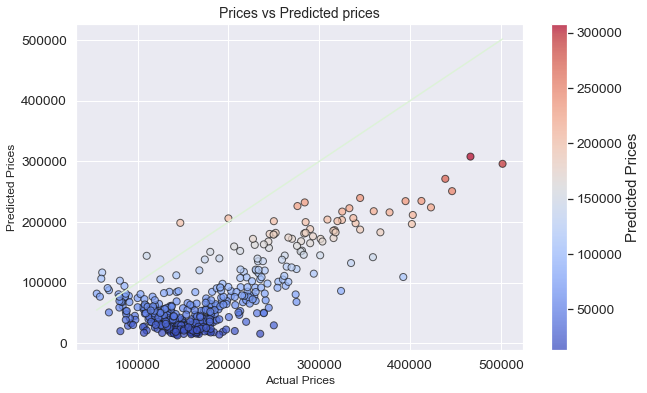

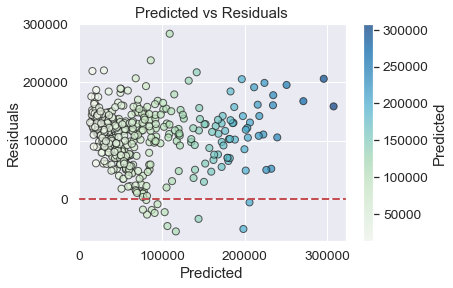

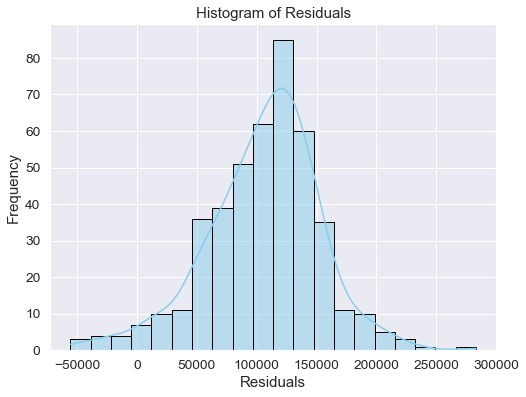

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
palette = sns.color_palette('viridis')

# Visualizing the differences between actual prices and predicted values

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.grid(True)
plt.show()

# Checking residuals

palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
